In [1]:
# Import libraries
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import os

from skimage.transform import resize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM, SimpleRNN
from keras.applications import imagenet_utils, ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.utils import to_categorical
from keras.optimizers import Adam

from scipy.sparse import csr_matrix

D:\Jupiter\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
f = h5py.File('spectrograms.h5', 'r')
species_keys = list(f.keys())
print('species keys:', species_keys)

species keys: ['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']


In [3]:
dset_1 = f['amecro']
dset_1.shape

(256, 343, 52)

In [4]:
dset_2 = f['barswa']
dset_2.shape

(256, 343, 55)

Species List: ['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']
Shape of data for one species: (256, 343, 52)


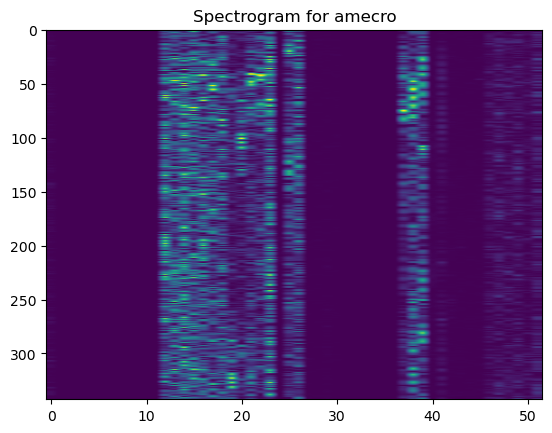

In [5]:
# Load the data
file_path = 'spectrograms.h5'
with h5py.File(file_path, 'r') as f:
    species_list = list(f.keys())
    print("Species List:", species_list)

    # Example: Loading data for a specific species
    species_data = f[species_list[0]]
    print("Shape of data for one species:", species_data.shape)

    # Loading data for all species
    data = {species: np.array(f[species]) for species in species_list}

# Checking data for one species
plt.imshow(data[species_list[0]][0], aspect='auto')
plt.title(f'Spectrogram for {species_list[0]}')
plt.show()

# Binary Model


In [6]:
# Select two species for binary classification, 'amecro' (American Crow) and 'houfin' (House Finch) 
selected_species = ['amecro', 'barswa']

In [7]:
from skimage.transform import resize   # resize() function from the skimage.transform module is used to resize the spectrograms

# Load the spectrogram data

file_path = 'spectrograms.h5'
with h5py.File(file_path, 'r') as f:
    # Get list of species keys
    species_keys = list(f.keys())
    print('Species keys:', species_keys)

    # Select the two species for binary classification
    species_1 = 'amecro'
    species_2 = 'houfin'
    dset_1 = f[species_1]
    dset_2 = f[species_2]

    # Check shapes of the selected species
    print(f'Shape of {species_1}:', dset_1.shape)
    print(f'Shape of {species_2}:', dset_2.shape)

    # Resize the spectrograms to have the same dimensions
    min_height = min(dset_1.shape[0], dset_2.shape[0])
    min_width = min(dset_1.shape[1], dset_2.shape[1])
    dset_1_resized = resize(dset_1[:, :, :min_width], (min_height, min_width, 3))
    dset_2_resized = resize(dset_2[:, :, :min_width], (min_height, min_width, 3))

    # Concatenate resized spectrograms of the selected species
    binary_spectrograms = np.concatenate([dset_1_resized, dset_2_resized])
    binary_labels = np.concatenate([np.full(dset_1_resized.shape[0], species_1), np.full(dset_2_resized.shape[0], species_2)])

Species keys: ['amecro', 'barswa', 'bkcchi', 'blujay', 'daejun', 'houfin', 'mallar3', 'norfli', 'rewbla', 'stejay', 'wesmea', 'whcspa']
Shape of amecro: (256, 343, 52)
Shape of houfin: (256, 343, 44)


In [8]:
binary_spectrograms.shape

(512, 343, 3)

In [9]:
binary_labels.shape

(512,)

In [10]:
# Resize spectrograms to match the expected input shape of the model
resized_spectrograms = np.array([resize(spec, (256, 343, 3)) for spec in binary_spectrograms])

In [11]:
resized_spectrograms.shape

(512, 256, 343, 3)

In [12]:
 # Step 3: Split Data into Train and Test Sets

X_train, X_test, y_train, y_test = train_test_split(resized_spectrograms, binary_labels, test_size=0.2, random_state=42)

In [13]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric format for both train and test sets
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [14]:
# Build and Train Binary Classification Model

binary_model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 343, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

D:\Jupiter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
binary_model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# Train the model(epochs = 10, batch size = 32)
history = binary_model.fit(X_train, y_train_encoded, epochs=10, batch_size=16, validation_split=0.2)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.5740 - loss: 1.0199 - val_accuracy: 0.7317 - val_loss: 0.5081
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7614 - loss: 0.4935 - val_accuracy: 0.8659 - val_loss: 0.3868
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.8563 - loss: 0.3782 - val_accuracy: 0.8780 - val_loss: 0.3376
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9204 - loss: 0.2915 - val_accuracy: 0.9878 - val_loss: 0.1478
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.9413 - loss: 0.2297 - val_accuracy: 1.0000 - val_loss: 0.0719
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.9484 - loss: 0.1475 - val_accuracy: 1.0000 - val_loss: 0.0508
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.9965 - loss: 0.0577 - val_accuracy: 1.0000 - val_loss: 0.0190
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 1.0000 - val_loss:

In [17]:
#Evaluate Binary Classification Model

# Evaluate the model on test set
loss, accuracy = binary_model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step - accuracy: 1.0000 - loss: 0.0132
Test Loss: 0.012890702113509178
Test Accuracy: 1.0


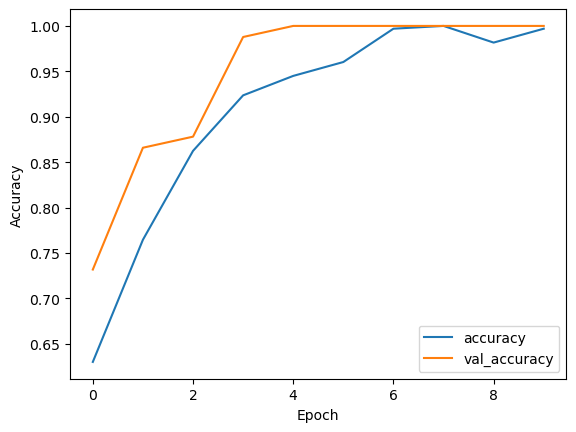

In [18]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Hyperparameter tuning

# Define the model
def create_binary_model(optimizer='adam', dropout_rate=0.5, neurons=128):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 343, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.5, 0.7],
    'neurons': [64, 128],
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64]
}

In [ ]:
# Dictionary to store the results
results = {}

# Perform manual grid search
for optimizer in param_grid['optimizer']:
    for dropout_rate in param_grid['dropout_rate']:
        for neurons in param_grid['neurons']:
            for epochs in param_grid['epochs']:
                for batch_size in param_grid['batch_size']:
                    print(f"Training with optimizer={optimizer}, dropout_rate={dropout_rate}, neurons={neurons}, epochs={epochs}, batch_size={batch_size}")
                    model = create_binary_model(optimizer, dropout_rate, neurons)
                    history = model.fit(X_train, y_train_encoded, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0)
                    loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
                    results[(optimizer, dropout_rate, neurons, epochs, batch_size)] = accuracy
                    print(f"Test Accuracy: {accuracy}")



In [ ]:
# Find the best hyperparameters
best_hyperparams = max(results, key=results.get)
print(f"Best hyperparameters: {best_hyperparams}")
print(f"Best accuracy: {results[best_hyperparams]}")


In [ ]:
# Plot training history for the best hyperparameters
best_model = create_binary_model(*best_hyperparams[:-2])
history = best_model.fit(X_train, y_train_encoded, epochs=best_hyperparams[-2], batch_size=best_hyperparams[-1], validation_split=0.2)

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:

# Print best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Evaluate best model on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Test Accuracy:", accuracy)

In [ ]:
# Tried to implement hyperparameter tuning and find optimal parameters, but the kernel kept on crashing due to high computational expense. 

# Multiclass Model


In [ ]:
# Multiclass Model

# Load the data from the HDF5 file
file_path = 'spectrograms.h5'
with h5py.File(file_path, 'r') as f:
    species_list = list(f.keys())
    print("Species List:", species_list)

    # Load data for all species
    data = {species: np.array(f[species]) for species in species_list}


In [ ]:
# Resize the spectrograms to have the same dimensions and concatenate them
from skimage.transform import resize

resized_spectrograms = []
labels = []
for species in species_list:
    species_data = data[species]
    for spec in species_data:
        resized_spectrograms.append(resize(spec, (256, 343, 3)))
        labels.append(species)

resized_spectrograms = np.array(resized_spectrograms)
labels = np.array(labels)
   

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(resized_spectrograms, labels, test_size=0.2, random_state=42)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode labels for neural network
one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = one_hot_encoder.fit_transform(y_train_encoded.reshape(-1, 1))
y_test_encoded = one_hot_encoder.transform(y_test_encoded.reshape(-1, 1))

In [ ]:
# Define the model creation function
def create_multiclass_model(optimizer='adam', dropout_rate=0.5, neurons=128):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 343, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(species_list), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Define and compile the model
multiclass_model = create_multiclass_model()

In [ ]:
# Train the model (example with 10 epochs and batch size 32)
history = multiclass_model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = multiclass_model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
# I tried the above code but I was encountering "Memory Error" due to huge dataset +and the kernel is crashing. So I implemented the code below code by reducing the size to overcome this problem. The code is below.

# Muticlass model at reduced size


In [19]:
# Define Data Generator
class DataGenerator(Sequence):
    def __init__(self, data, labels, batch_size=16, shuffle=True, resize_shape=(128, 171, 3)):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.resize_shape = resize_shape
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = [resize(self.data[i], self.resize_shape) for i in batch_indices]
        batch_labels = self.labels[batch_indices]
        return np.array(batch_data), np.array(batch_labels)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [20]:
# Load the data
file_path = 'spectrograms.h5'
with h5py.File(file_path, 'r') as f:
    species_list = list(f.keys())
    data = {species: np.array(f[species]) for species in species_list}

In [21]:
# Prepare data and labels
resized_spectrograms = []
labels = []
resize_shape = (128, 171, 3)  # Reshape to this reduced input size for uniformity
for species in species_list:
    species_data = data[species]
    for spec in species_data:
        resized_spectrograms.append(resize(spec, resize_shape))
        labels.append(species)

resized_spectrograms = np.array(resized_spectrograms)
labels = np.array(labels)


In [22]:
# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# One-hot encode labels for neural network
one_hot_encoder = OneHotEncoder(sparse_output=False)
encoded_labels = one_hot_encoder.fit_transform(encoded_labels.reshape(-1, 1))

In [23]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(resized_spectrograms, encoded_labels, test_size=0.2, random_state=42)

In [24]:
# Create data generators
batch_size = 16
train_generator = DataGenerator(X_train, y_train, batch_size=batch_size)
test_generator = DataGenerator(X_test, y_test, batch_size=batch_size, shuffle=False)

In [25]:
# Define the simplified model creation function
def create_simplified_model(optimizer='adam', dropout_rate=0.5, neurons=64):
    model = Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(128, 171, 3)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(neurons, activation='relu'),
        Dropout(dropout_rate),
        Dense(len(species_list), activation='softmax')
    ])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [26]:
# Define and compile the simplified model
simplified_model = create_simplified_model()

D:\Jupiter\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [27]:
# Train the simplified model
history = simplified_model.fit(train_generator, epochs=10, validation_data=test_generator)


Epoch 1/10


D:\Jupiter\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 53s 250ms/step - accuracy: 0.5516 - loss: 1.6228 - val_accuracy: 0.9918 - val_loss: 0.1190
Epoch 2/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 38s 244ms/step - accuracy: 0.9354 - loss: 0.3214 - val_accuracy: 0.9984 - val_loss: 0.0160
Epoch 3/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 31s 198ms/step - accuracy: 0.9705 - loss: 0.1138 - val_accuracy: 0.9934 - val_loss: 0.0186
Epoch 4/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.9701 - loss: 0.1250 - val_accuracy: 0.9934 - val_loss: 0.0347
Epoch 5/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 193ms/step - accuracy: 0.9724 - loss: 0.1068 - val_accuracy: 1.0000 - val_loss: 0.0018
Epoch 6/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.9825 - loss: 0.0661 - val_accuracy: 1.0000 - val_loss: 6.7714e-04
Epoch 7/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 192ms/step - accuracy: 0.9928 - loss: 0.0433 - val_accuracy: 1.0000 - val_loss: 2.4802e-04
Epoch 8/10
153/153 ━━━━━━━━━━━━━━━━━━━━ 30s 190ms/step - accuracy: 0.9874 - loss: 0.05

In [28]:
# Evaluate the simplified model on the test set
loss, accuracy = simplified_model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 1.0000 - loss: 3.6362e-05
Test Loss: 3.0712275474797934e-05
Test Accuracy: 1.0


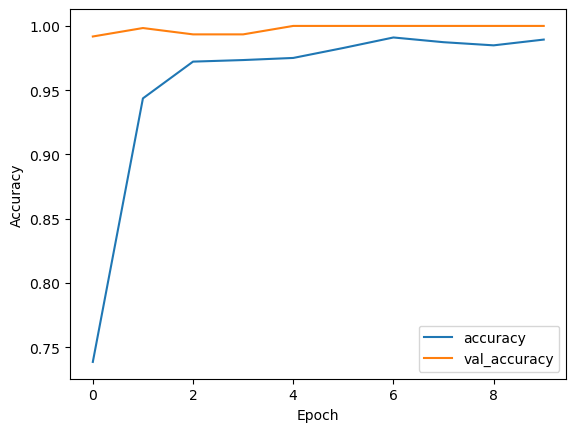

In [29]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# External test

In [ ]:
# Install librosa
!pip install librosa

In [39]:
# Dictionary that maps each species code to its full name.

species_full_names = {
    'amecro': 'American Crow',
    'barswa': 'Barn Swallow',
    'bkcchi': 'Black-capped Chickadee',
    'blujay': 'Blue Jay',
    'daejun': 'Dark-eyes Junco',
    'houfin': 'House Finch',
    'mallar3': 'Mallard',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'stejay': "Steller's Jay",
    'wesmea': 'Western Meadowlark',
    'whcspa': 'White-crowned Sparrow'
}

In [40]:
# Convert MP3 files to Spectrograms
import librosa
import librosa.display

def mp3_to_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB


In [41]:
# Convert external test mp3 files to spectrograms
test_folder = 'test_birds'
test_files = [os.path.join(test_folder, file) for file in ['test1.mp3', 'test2.mp3', 'test3.mp3']]
test_spectrograms = [mp3_to_spectrogram(file) for file in test_files]

In [42]:
# Resize spectrograms to match the input shape of the binary model
binary_resize_shape = (256, 343)
binary_test_spectrograms = [resize(spec, binary_resize_shape) for spec in test_spectrograms]
binary_test_spectrograms = np.array(binary_test_spectrograms)

# Expand dimensions to match model input shape (batch_size, height, width, channels)
binary_test_spectrograms = np.expand_dims(binary_test_spectrograms, axis=-1)
binary_test_spectrograms = np.repeat(binary_test_spectrograms, 3, axis=-1)  # Convert to 3-channel RGB


In [43]:
# Resize spectrograms to match the input shape of the multiclass model
multiclass_resize_shape = (128, 171)
multiclass_test_spectrograms = [resize(spec, multiclass_resize_shape) for spec in test_spectrograms]
multiclass_test_spectrograms = np.array(multiclass_test_spectrograms)

# Expand dimensions to match model input shape (batch_size, height, width, channels)
multiclass_test_spectrograms = np.expand_dims(multiclass_test_spectrograms, axis=-1)
multiclass_test_spectrograms = np.repeat(multiclass_test_spectrograms, 3, axis=-1)  # Convert to 3-channel RGB


In [34]:
# Predict with the binary model
binary_predictions = binary_model.predict(binary_test_spectrograms)

# Convert predictions to species labels
binary_species_predictions = label_encoder.inverse_transform((binary_predictions > 0.5).astype(int).flatten())

for i, pred in enumerate(binary_species_predictions):
    print(f"Test clip {i + 1} binary prediction: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Test clip 1 binary prediction: barswa
Test clip 2 binary prediction: barswa
Test clip 3 binary prediction: barswa


In [35]:
# Predict with the simplified multiclass model
multiclass_predictions = simplified_model.predict(multiclass_test_spectrograms)

# Convert predictions to species labels
multiclass_species_predictions = label_encoder.inverse_transform(np.argmax(multiclass_predictions, axis=1))

for i, pred in enumerate(multiclass_species_predictions):
    print(f"Test clip {i + 1} multiclass prediction: {pred}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Test clip 1 multiclass prediction: whcspa
Test clip 2 multiclass prediction: whcspa
Test clip 3 multiclass prediction: whcspa


In [37]:
import pandas as pd

# Create a summary table
summary = {
    "Test Clip": [f"Test Clip {i + 1}" for i in range(len(test_files))],
    "Binary Prediction": binary_species_predictions,
    "Multiclass Prediction": multiclass_species_predictions
}

summary_df = pd.DataFrame(summary)
print(summary_df)


     Test Clip Binary Prediction Multiclass Prediction
0  Test Clip 1            barswa                whcspa
1  Test Clip 2            barswa                whcspa
2  Test Clip 3            barswa                whcspa


In [ ]:
# Code to produces predicted bird with fullnames

In [48]:
# Dictionary that maps each species code to its full name
species_full_names = {
    'amecro': 'American Crow',
    'barswa': 'Barn Swallow',
    'bkcchi': 'Black-capped Chickadee',
    'blujay': 'Blue Jay',
    'daejun': 'Dark-eyed Junco',
    'houfin': 'House Finch',
    'mallar3': 'Mallard',
    'norfli': 'Northern Flicker',
    'rewbla': 'Red-winged Blackbird',
    'stejay': "Steller's Jay",
    'wesmea': 'Western Meadowlark',
    'whcspa': 'White-crowned Sparrow'
}

# Convert MP3 files to Spectrograms
def mp3_to_spectrogram(file_path):
    y, sr = librosa.load(file_path)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

# Convert external test mp3 files to spectrograms
test_folder = 'test_birds'
test_files = [os.path.join(test_folder, file) for file in ['test1.mp3', 'test2.mp3', 'test3.mp3']]
test_spectrograms = [mp3_to_spectrogram(file) for file in test_files]

# Resize spectrograms to match the input shape of the binary model
binary_resize_shape = (256, 343)
binary_test_spectrograms = [resize(spec, binary_resize_shape) for spec in test_spectrograms]
binary_test_spectrograms = np.array(binary_test_spectrograms)

# Expand dimensions to match model input shape (batch_size, height, width, channels)
binary_test_spectrograms = np.expand_dims(binary_test_spectrograms, axis=-1)
binary_test_spectrograms = np.repeat(binary_test_spectrograms, 3, axis=-1)  # Convert to 3-channel RGB

# Resize spectrograms to match the input shape of the multiclass model
multiclass_resize_shape = (128, 171)
multiclass_test_spectrograms = [resize(spec, multiclass_resize_shape) for spec in test_spectrograms]
multiclass_test_spectrograms = np.array(multiclass_test_spectrograms)

# Expand dimensions to match model input shape (batch_size, height, width, channels)
multiclass_test_spectrograms = np.expand_dims(multiclass_test_spectrograms, axis=-1)
multiclass_test_spectrograms = np.repeat(multiclass_test_spectrograms, 3, axis=-1)  # Convert to 3-channel RGB

# Predict with the binary model
binary_predictions = binary_model.predict(binary_test_spectrograms)

# Convert predictions to species labels
binary_species_predictions = ['American Crow' if pred < 0.5 else 'Barn Swallow' for pred in binary_predictions.flatten()]

for i, pred in enumerate(binary_species_predictions):
    print(f"Test clip {i + 1} binary prediction: {pred}")

# Predict with the simplified multiclass model
multiclass_predictions = simplified_model.predict(multiclass_test_spectrograms)

# Convert predictions to species labels
multiclass_species_predictions = [species_full_names[label_encoder.inverse_transform([np.argmax(pred)])[0]] for pred in multiclass_predictions]

for i, pred in enumerate(multiclass_species_predictions):
    print(f"Test clip {i + 1} multiclass prediction: {pred}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
Test clip 1 binary prediction: Barn Swallow
Test clip 2 binary prediction: Barn Swallow
Test clip 3 binary prediction: Barn Swallow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Test clip 1 multiclass prediction: White-crowned Sparrow
Test clip 2 multiclass prediction: White-crowned Sparrow
Test clip 3 multiclass prediction: White-crowned Sparrow


In [49]:
# Create a summary table
summary = {
    "Test Clip": [f"Test Clip {i + 1}" for i in range(len(test_files))],
    "Binary Prediction": binary_species_predictions,
    "Multiclass Prediction": multiclass_species_predictions
}

summary_df = pd.DataFrame(summary)
print(summary_df)

     Test Clip Binary Prediction  Multiclass Prediction
0  Test Clip 1      Barn Swallow  White-crowned Sparrow
1  Test Clip 2      Barn Swallow  White-crowned Sparrow
2  Test Clip 3      Barn Swallow  White-crowned Sparrow
